In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [403]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats

from bprime.genome import Genome
from bprime.sim_utils import read_params, get_bounds
from bprime.theory import bgs_segment
from bprime.models import BGSModel 
from bprime.utils import dist_to_segment, bin_chrom, haldanes_mapfun, signif
from bprime.samplers import Sampler

In [7]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')


## Load Annotation

Load in human annotation to get a sense of the scale/range of parameters.

In [122]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")
g.load_annot("../data/annotation/conserved_slop.bed.gz")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

m = BGSModel(g, 
             w_grid=np.array([1e-8]),
             t_grid=np.array([0.01]))

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr1.
completed segmenting chr2.
completed segmenting chr3.
completed segmenting chr4.
completed segmenting chr5.
completed segmenting chr6.
completed segmenting chr7.
completed segmenting chr8.
completed segmenting chr9.
completed segmenting chr10.
completed segmenting chr11.
completed segmenting chr12.
completed segmenting chr13.
completed segmenting chr14.
completed segmenting chr15.
completed segmenting chr16.
completed segmenting chr17.
completed segmenting chr18.
completed segmenting chr19.
completed segmenting chr20.
completed segmenting chr21.
completed segmenting chr22.
looking up map positions...	done.


## The Scale and Range of Parameters in the Human Genome


### Recombination
What's the range of recombination rates?

In [26]:
recmap = m.recmap

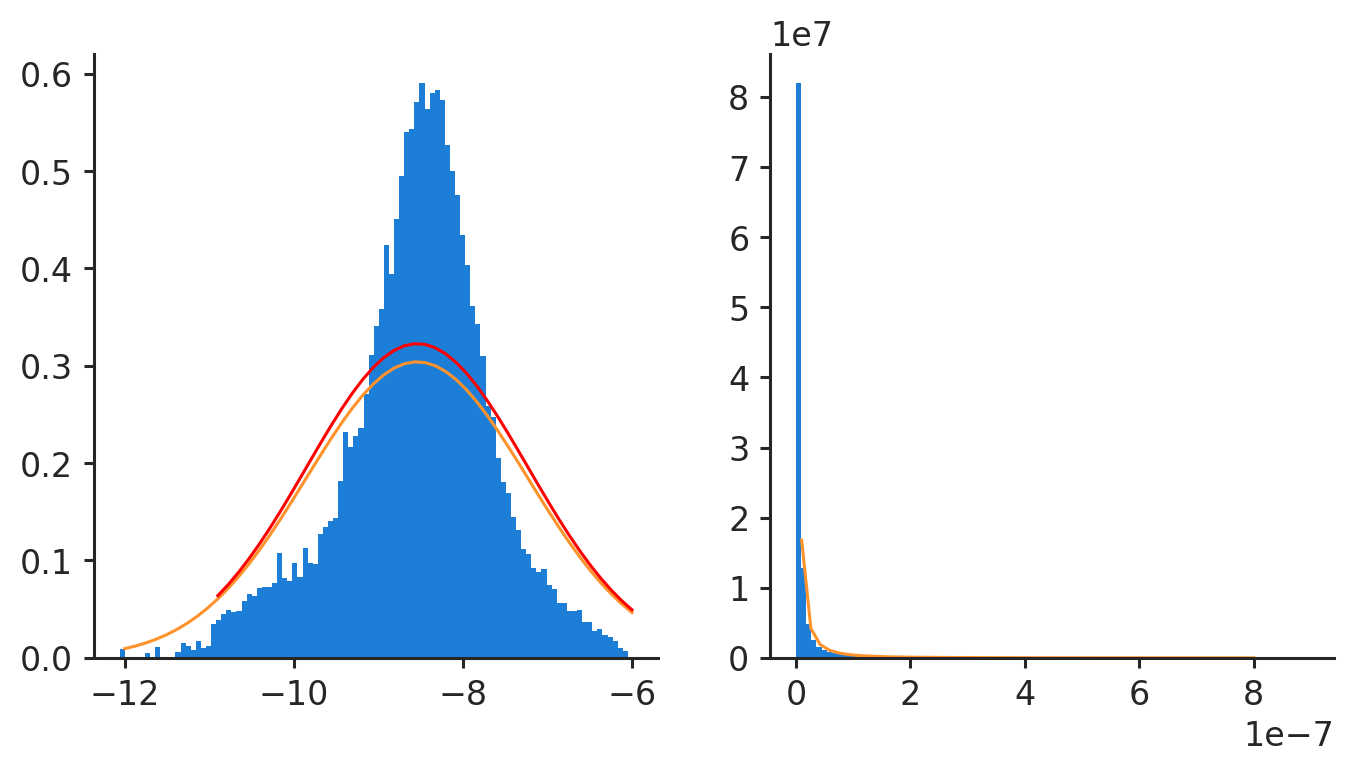

In [473]:
ends, rates = recmap.rates['chr10']
rates = rates[~np.isnan(rates)]
log10_rates = np.log10(rates[rates>0])
fig, ax = plt.subplots(ncols=2)
ax[0].hist(log10_rates, 100, density=True)
ax[1].hist(rates, 100, density=True)

# zero removed, log10'd
rbps_params_alt = stats.norm.fit(log10_rates)
x = np.linspace(-12, -6)
flattened_rbps_params_alt = flatten(*rbps_params_alt, 1.5)
ax[0].plot(x, stats.norm(*flattened_rbps_params_alt).pdf(x))

low, high, loc, scale = -11, -6, -8.54, 1.31
a = (low - loc)/scale
b = (high - loc)/scale
ax[0].plot(x[x > -11], stats.truncnorm(a, b, loc, scale).pdf(x[x > -11]), c='r')


# log normal                       
rbps_params = stats.lognorm.fit(rates)
x = np.linspace(1e-8, 8e-7)
ax[1].plot(x, stats.lognorm(*rbps_params).pdf(x))


In [323]:
mode_height = stats.truncnorm(a, b, loc, scale).pdf(loc)
mode_height/stats.truncnorm(a, b, loc, scale).pdf(low), mode_height/stats.truncnorm(a, b, loc, scale).pdf(high)

(32.72126503277982, 6.551717890508179)

In [141]:
flattened_rbps_params_alt

(-8.541934686504534, 1.3118919357924543)

### What's the range of random recombination fractions?

Take a sample of positions, compute the map distances to all features, and look at the range and distribution of this.

In [107]:
x = np.random.uniform(0, recmap.cumm_rates['chr1'].rate[-1], 500)

In [108]:
y = np.array([dist_to_segment(f, m.segments.map_pos) for f in x]).flatten()

In [109]:
y[y > 0].min(), y[y > 0].max()

(4.55798454535028e-10, 2.9363121456092953)

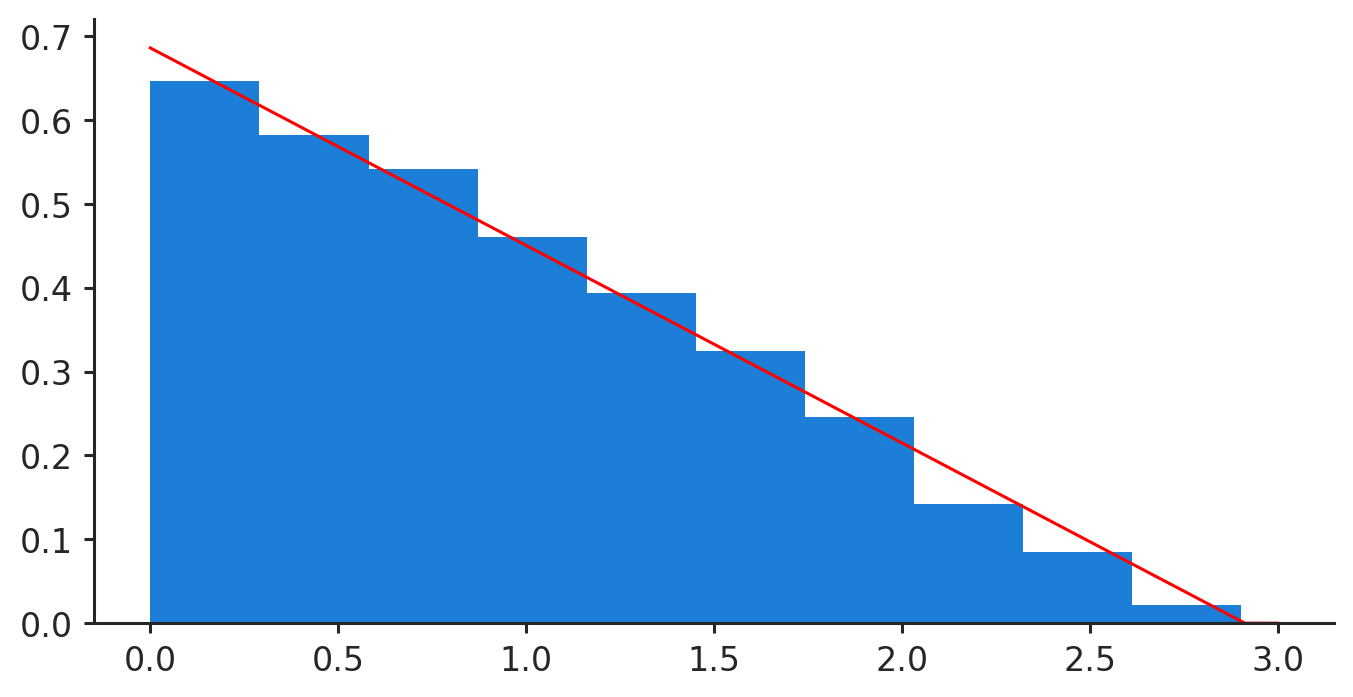

In [146]:
y_subsamp = y[np.random.randint(0, len(y), 10_000)]
rf_params = stats.triang.fit(y_subsamp)
x = np.linspace(0, 3, 1000)
plt.hist(y_subsamp, density=True)
#shape, location, scale = rf_params[0], rf_params[1], rf_params[2]*1.3
plt.plot(x, stats.triang(*rf_params).pdf(x), c='r')

(array([1.4411078 , 1.41359767, 1.64849189, 1.80932037, 1.94475487,
        2.22408854, 2.58383645, 2.74889726, 3.21022105, 2.13732581]),
 array([2.31021183e-05, 4.72784150e-02, 9.45337279e-02, 1.41789041e-01,
        1.89044354e-01, 2.36299666e-01, 2.83554979e-01, 3.30810292e-01,
        3.78065605e-01, 4.25320918e-01, 4.72576231e-01]),
 <BarContainer object of 10 artists>)

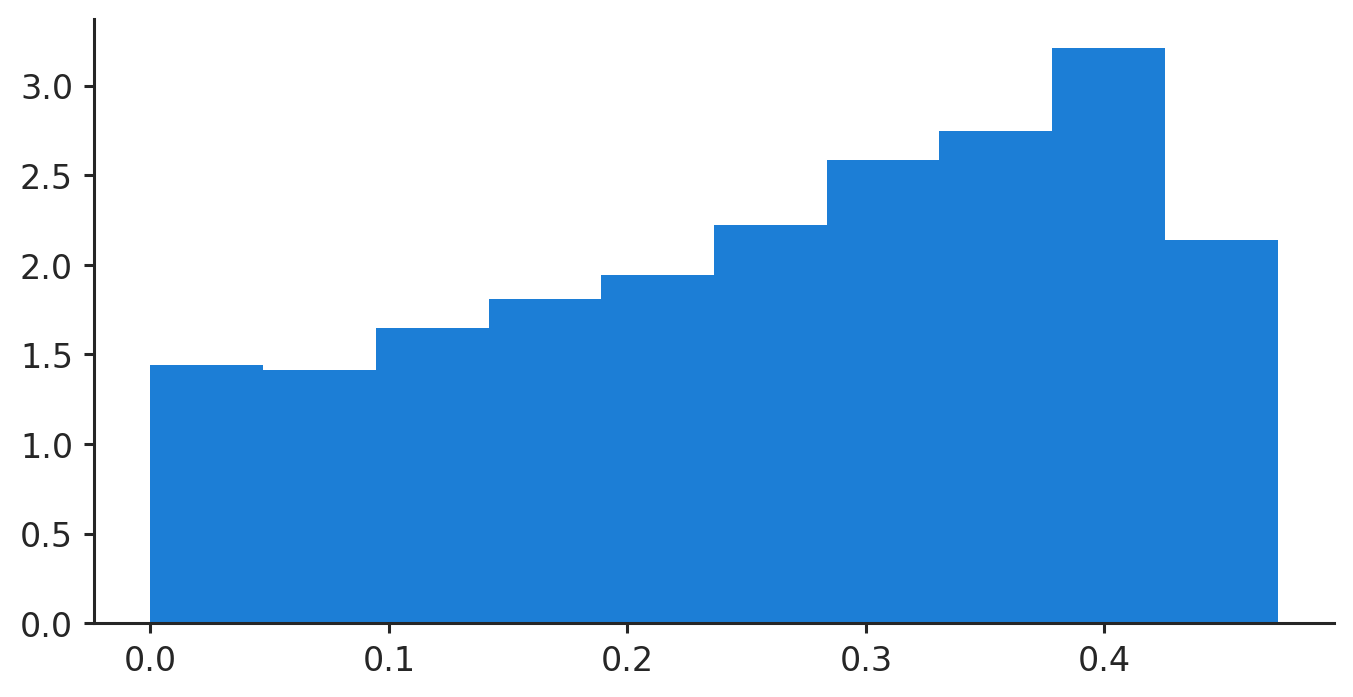

In [148]:
plt.hist(haldanes_mapfun(y_subsamp), density=True)

In [145]:
shape, location, scale

(4.643807107910257e-09, 0.00018090739502623905, 3.788225441560212)

However there's a problem here — the $B$ values are quickly close to 1 for the bulk of this parameter space. We don't benefit in learning the functional form of $B$ by sampling in regions where it does not vary.

### What's the Range of Segment Lengths?

In [125]:
lengths = m.segments.lengths
log10_lengths = np.log10(lengths)
m.segments.lengths.min(), m.segments.lengths.max()

(1, 1000)

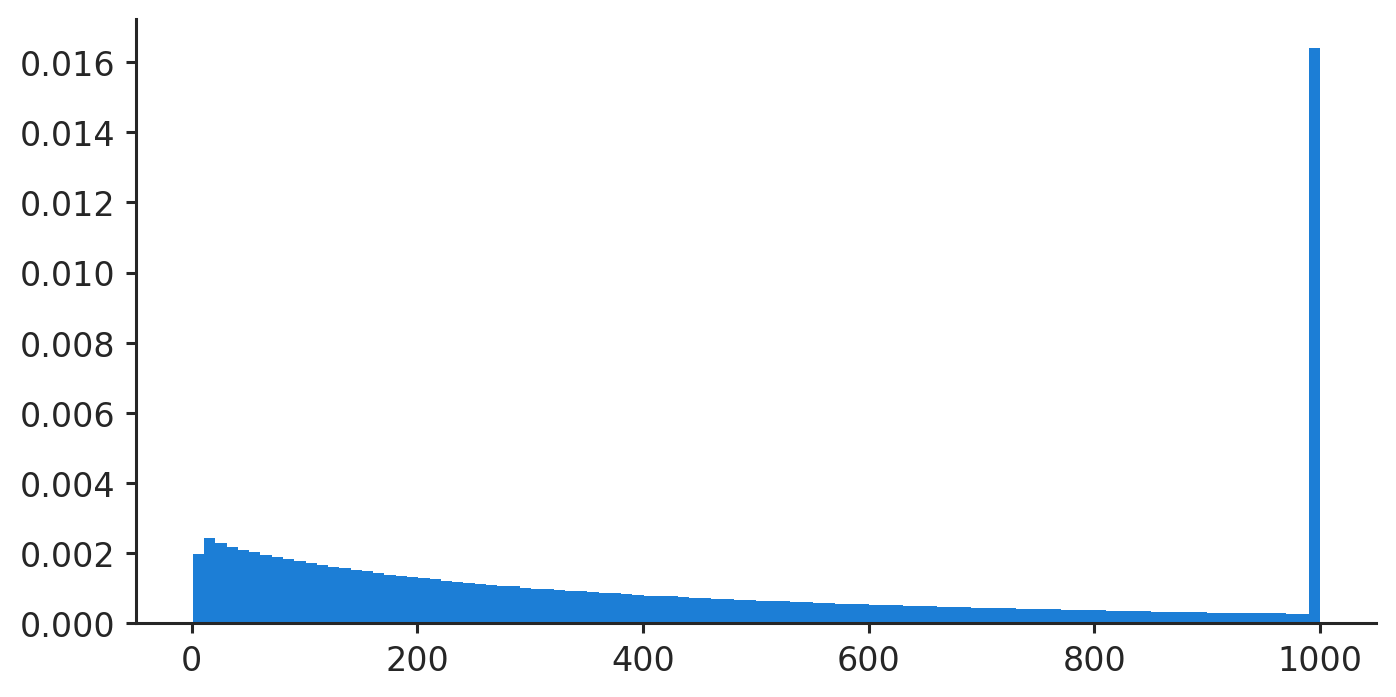

In [131]:
_ = plt.hist(lengths, 100, density=True)

## Parameters from JSON File

In [519]:
with open('../slim_sims/training/fullbgs_dist.json') as f:
    params = json.load(f)['params']

sampler = Sampler(params, 1000)
sampler

Sampler with 1000/1000 samples remaining, seed=None
  N ~ fixed(val=1000)
  mu ~ log10_truncnormal(low=-10, high=-6, loc=-8, scale=1.2)
  s ~ log10_uniform(low=-5, high=-1)
  h ~ fixed(val=0.5)
  rf ~ log10_truncnormal(low=-10, high=-1, loc=-7.5, scale=3.5)
  rbp ~ log10_truncnormal(low=-11, high=-6, loc=-8.54, scale=1.3)
  L ~ discrete_uniform(low=1, high=1101)

In [520]:
sampler.generate()

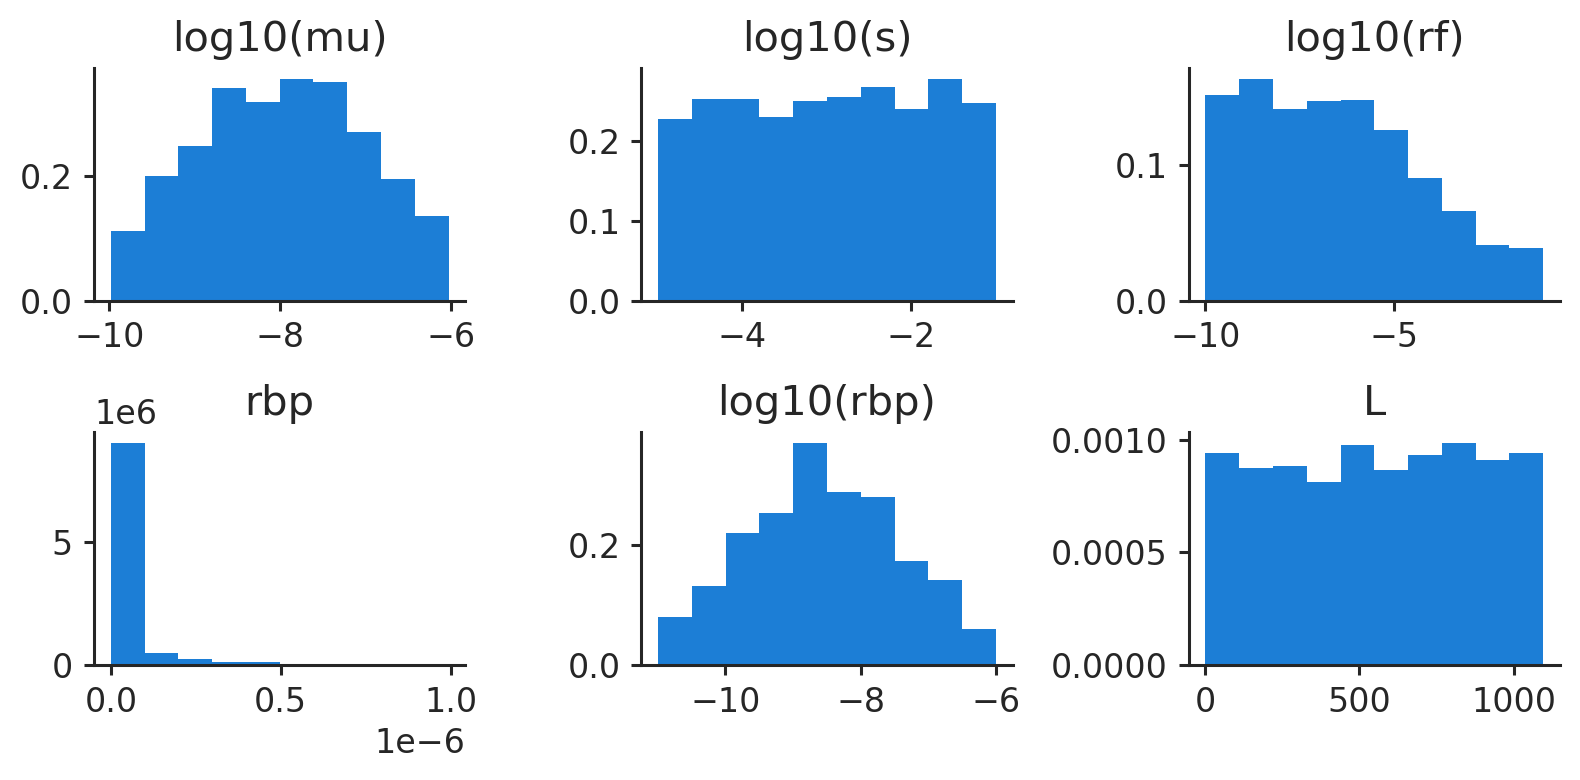

In [523]:
fig, ax = plt.subplots(ncols=3, nrows=2)

plt_info = [(0, 0, 'mu', True), (0, 1, 's', True), (0, 2, 'rf', True), (1, 0, 'rbp', False), (1, 1, 'rbp', True), (1,  2, 'L', False)]
for i, j, var, log10 in plt_info:
    x = sampler[var]
    if log10:
        x = np.log10(x)
        var = f"log10({var})"
    ax[i, j].hist(x, density=True)
    ax[i, j].set_title(var)
plt.tight_layout()

### Expected Reductions under Classic BGS

In [333]:
sim_bounds = get_bounds(params)
sim_bounds

{'N': (1000, 1000, False),
 'mu': (1e-10, 1e-05, False),
 's': (-5, -1, True),
 'h': (0.5, 0.5, False),
 'rf': (0, 0.5, False),
 'rbp': (-12, -6, True),
 'L': (1, 1101, False)}

In [334]:
kwargs_lower, kwargs_upper = {}, {}

kwargs = ('mu', 's', 'rf', 'rbp', 'L')
# B is inversely proportional to these things under classic BGS
swap = ('s', 'rf', 'rbp')
for key, (lower, upper, log10) in sim_bounds.items():
    if key not in kwargs:
        continue
    if log10:
        lower, upper = 10**lower, 10**upper
    if key in swap:
        lower, upper = upper, lower
    kwargs_lower[key] = lower
    kwargs_upper[key] = upper

In [335]:
kwargs_lower, kwargs_upper

({'mu': 1e-10, 's': 0.1, 'rf': 0.5, 'rbp': 1e-06, 'L': 1},
 {'mu': 1e-05, 's': 1e-05, 'rf': 0, 'rbp': 1e-12, 'L': 1101})

In [336]:
bgs_segment(**kwargs_lower), bgs_segment(**kwargs_upper)

(array(1.), array(0.))

In [367]:
# how much should rf vary?
rfs = np.logspace(-10, 0, 100)

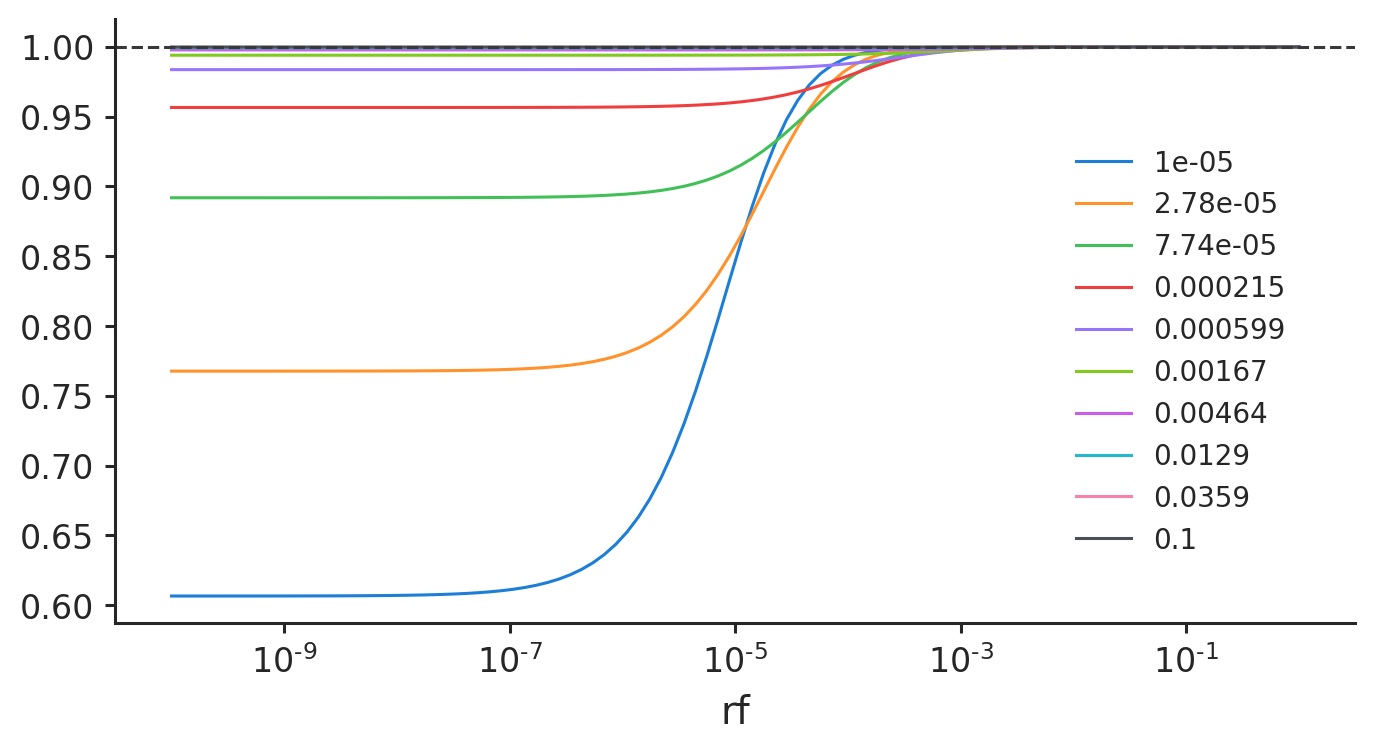

In [405]:
selcoefs = 10**np.linspace(-5, -1, 10)

fig, ax = plt.subplots()
for i, s in enumerate(selcoefs):
    kwargs = {'mu': 1e-08, 's': s, 'rf': rfs, 'rbp': 1e-8, 'L': 1000}
    B = bgs_segment(**kwargs)
    ax.plot(rfs, B, label=signif(s, 3))
ax.axhline(1, c='0.22', linestyle='dashed')
ax.set_xlabel('rf')
ax.set_xscale('log')
ax.legend()

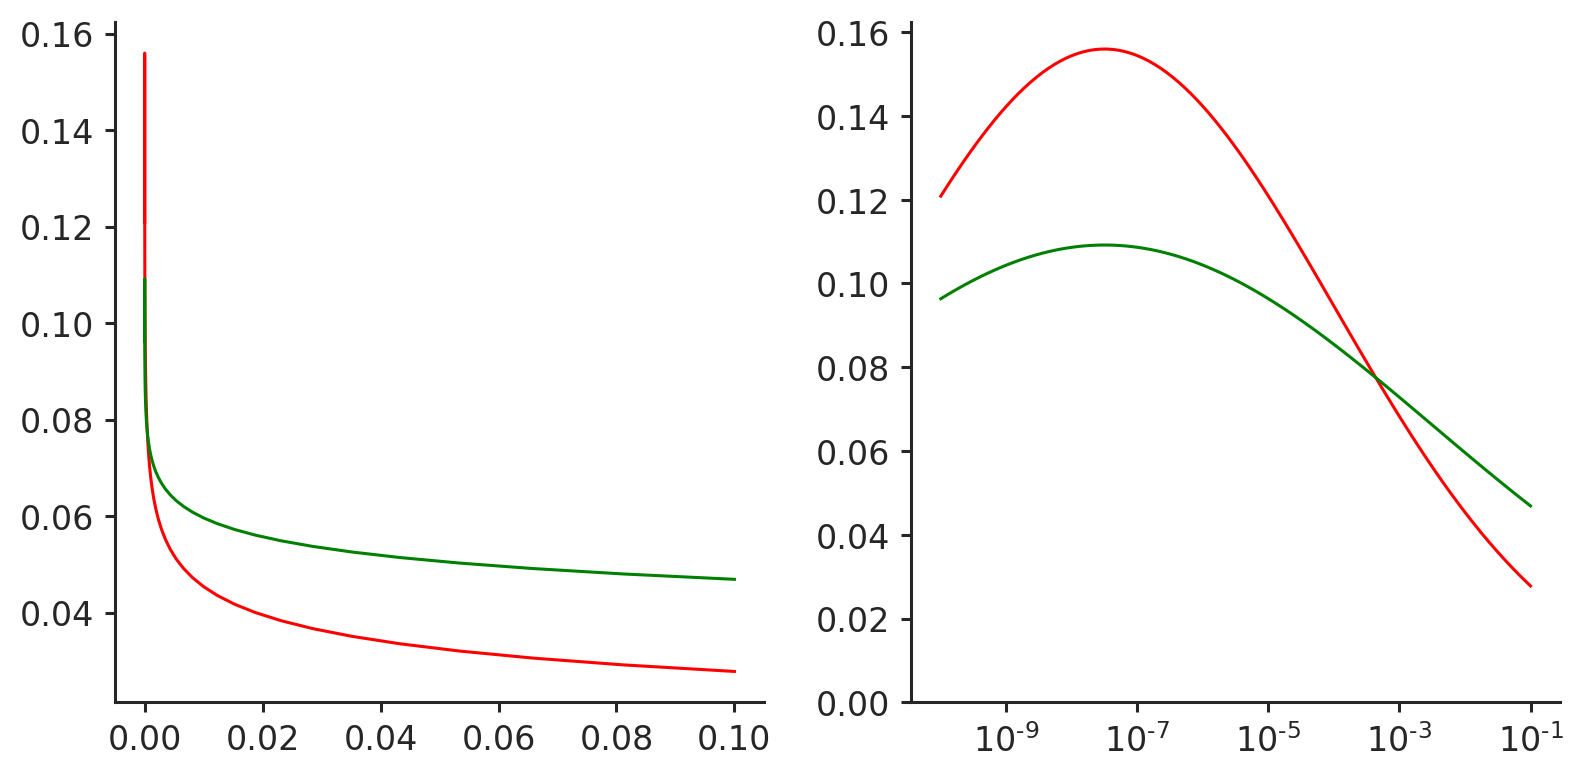

In [460]:
fig, ax = plt.subplots(ncols=2)
low, high, loc, scale = -10, -1, -7.5, 3.5
a = (low - loc)/scale
b = (high - loc)/scale
x = 10**np.linspace(-10, -1, 100)
ax[0].plot(x, stats.truncnorm(a, b, loc, scale).pdf(np.log10(x)), c='r')
ax[1].plot(x, stats.truncnorm(a, b, loc, scale).pdf(np.log10(x)), c='r')
ax[1].plot(x, stats.truncnorm(a, b, loc, 5).pdf(np.log10(x)), c='g')
ax[0].plot(x, stats.truncnorm(a, b, loc, 5).pdf(np.log10(x)), c='g')

#ax[1].plot(x, stats.loguniform(10**low, 10**high).pdf(x), c='b')
#ax[1].set_ylim(0, 0.2)
#ax[1].set_xlim(10**low, 10**high)
ax[1].set_ylim(0)
ax[1].semilogx()
plt.tight_layout()

[]

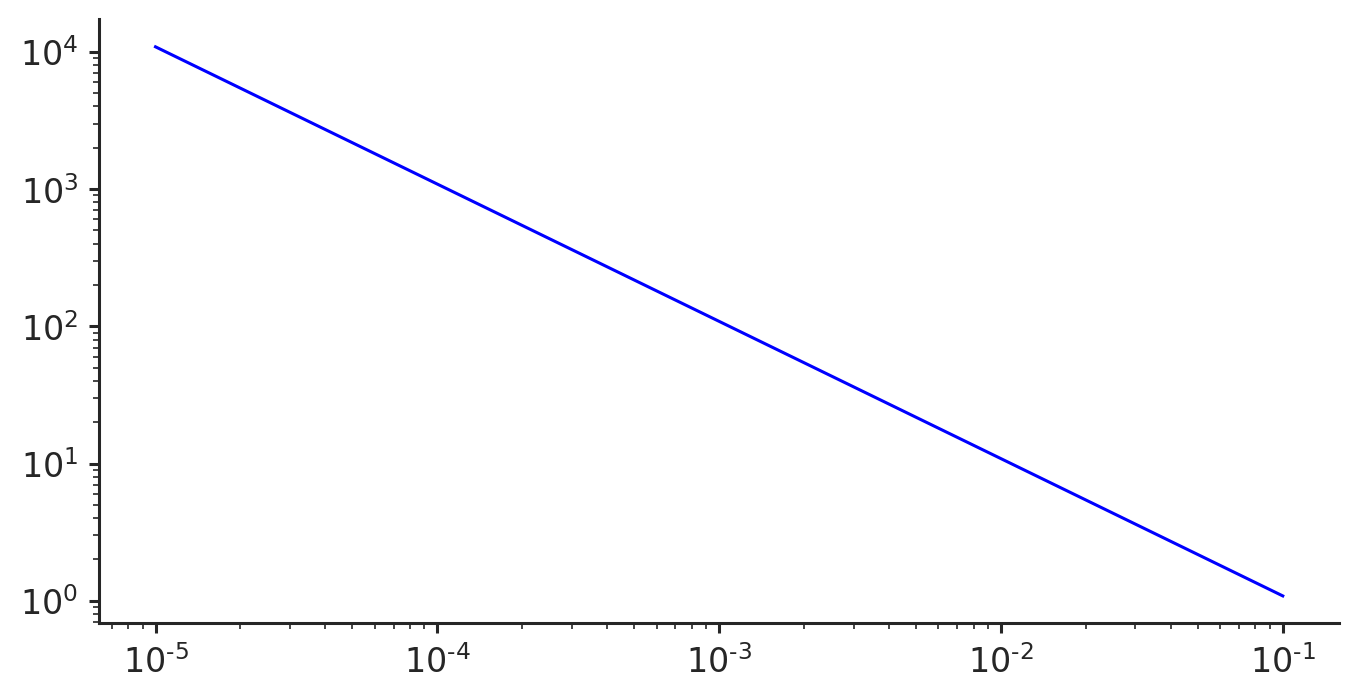

In [465]:
x = 10**np.linspace(-5, -1, 10)
plt.plot(x, stats.loguniform(1e-5, 1e-1).pdf(x), c='b')
plt.loglog()


In [476]:
np.random.binomial(

<function RandomState.binomial>

(array([662.,  50.,  25.,  25.,  10.,  11.,  13.,  11.,  12.,   6.,   9.,
          7.,   6.,   4.,   7.,   5.,   2.,   9.,   4.,   4.,   4.,   5.,
          2.,   5.,   1.,   0.,   2.,   3.,   2.,   1.,   2.,   3.,   1.,
          5.,   3.,   5.,   1.,   4.,   2.,   1.,   2.,   2.,   0.,   3.,
          2.,   3.,   1.,   2.,   3.,   3.,   2.,   2.,   2.,   0.,   2.,
          2.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   1.,   2.,   1.,   0.,   0.,   1.,   1.,   2.,   1.,   1.,
          3.,   1.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   1.,   1.,
          0.,   3.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,
          1.]),
 array([1.00133254e-10, 9.99763321e-07, 1.99942651e-06, 2.99908970e-06,
        3.99875288e-06, 4.99841607e-06, 5.99807926e-06, 6.99774244e-06,
        7.99740563e-06, 8.99706882e-06, 9.99673201e-06, 1.09963952e-05,
        1.19960584e-05, 1.29957216e-05, 1.39953848e-05, 1.49950479e-05,
        1.59947111e-05, 1.6994

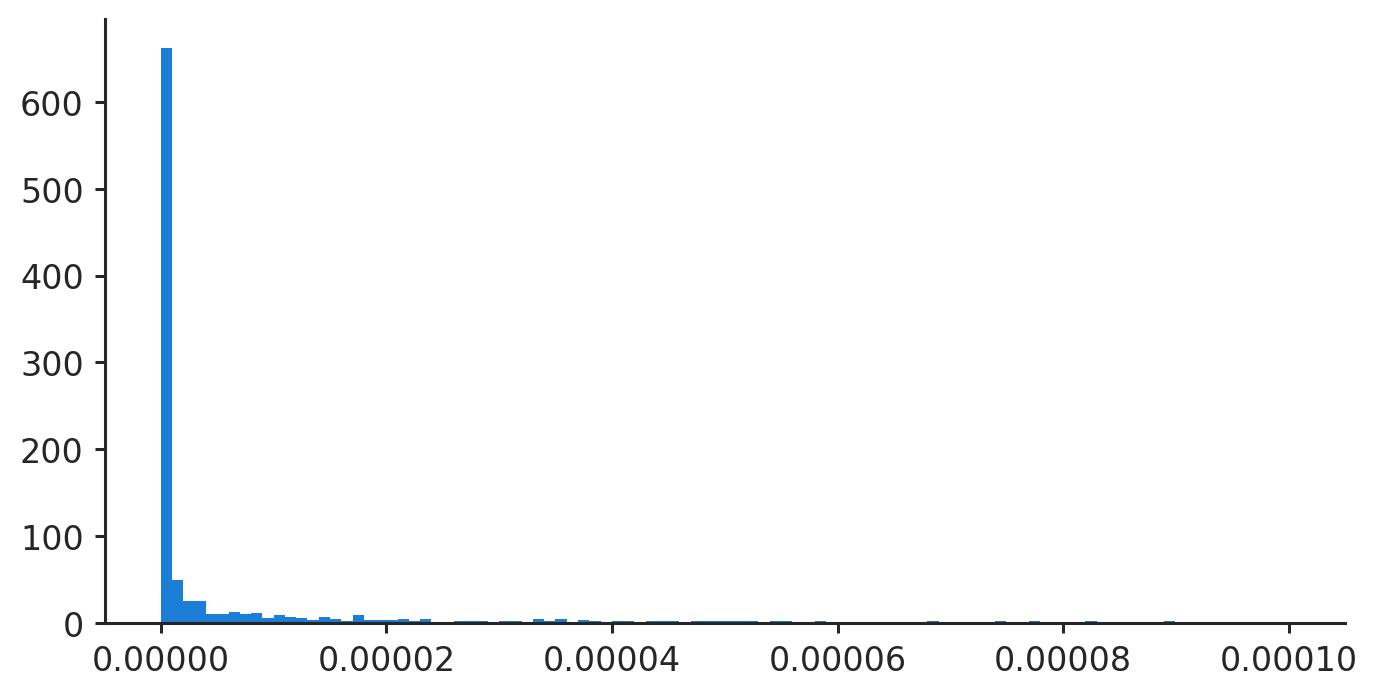

In [488]:
def log_linear_mixture(low, high, n, prob_log=1/2):
    x = np.zeros(n)
    idx = np.random.binomial(1, prob_log, size=n).astype('bool')
    n_log = idx.sum()
    x[idx] = 10**np.random.uniform(low, high, n_log)
    x[~idx] = np.random.uniform(10**low, 10**high, n - n_log)
    return x

plt.hist((log_linear_mixture(-10, -4, 1000, prob_log=1)), 100)